In [22]:
# Install required packages
!pip install unsloth sacrebleu evaluate matplotlib kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.5 MB/s eta 0:00:00


In [2]:
# Download base model
from huggingface_hub import snapshot_download
snapshot_download(
    repo_id="unsloth/gemma-3-270m",
    local_dir="/kaggle/working/gemma3",
    local_dir_use_symlinks=False,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

'/kaggle/working/gemma3'

In [3]:
# Import libraries
from unsloth import FastLanguageModel
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
from unsloth.chat_templates import train_on_responses_only
import torch, json, math
from torch.utils.data import DataLoader
import evaluate
from sklearn.metrics import f1_score
import pandas as pd

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-10-15 15:02:25.071144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760540545.098825    1026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760540545.107789    1026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    "/kaggle/working/gemma3",
    max_seq_length=2048,
    load_in_4bit=True,
    full_finetuning=False,
)

# Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    lora_alpha=128,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.0,
    bias="none",
    use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2025.10.3: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
Unsloth: Making `model.base_model.model.model` require gradients


In [5]:
# Load and split dataset
data = load_dataset("json", data_files="/kaggle/input/cura-medica-v2-data/symptom-disease-doctor-final.jsonl")["train"]
data = data.train_test_split(test_size=0.2, seed=42)
train_data, test_data = data["train"], data["test"]

In [6]:
# Formatting
def formatting_func(examples):
    texts = []
    for msgs in examples["messages"]:
        if isinstance(msgs, str):
            msgs = json.loads(msgs)
        parts = []
        for m in msgs:
            role = "user" if m.get("role") == "user" else "model"
            parts.append(f"<start_of_turn>{role}\n{m['content']}<end_of_turn>")
        texts.append("\n".join(parts))
    return {"text": texts}

train_processed = train_data.map(formatting_func, batched=True, remove_columns=train_data.column_names)
test_processed = test_data.map(formatting_func, batched=True, remove_columns=test_data.column_names)

In [7]:
# Prepare trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_processed,
    dataset_text_field="text",
    max_seq_length=2048,
    args=SFTConfig(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=8,
        warmup_steps=50,
        num_train_epochs=3,
        learning_rate=2e-4,
        max_grad_norm=1.0,
        logging_steps=200,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        save_strategy="epoch",
        save_total_limit=2,
        dataloader_pin_memory=False,
        report_to="none",
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


In [8]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 22,252 | Num Epochs = 3 | Total steps = 2,088
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 15,187,968 of 283,286,144 (5.36% trained)


Step,Training Loss
200,1.416700
400,0.863900
600,0.841000
800,0.803400
1000,0.761800
1200,0.763500
1400,0.740200
1600,0.709900
1800,0.691700
2000,0.672300


TrainOutput(global_step=2088, training_loss=0.820089089916127, metrics={'train_runtime': 5228.6833, 'train_samples_per_second': 12.767, 'train_steps_per_second': 0.399, 'total_flos': 3557998895560704.0, 'train_loss': 0.820089089916127, 'epoch': 3.0})

BLEU Score: 0.0069273106279722635


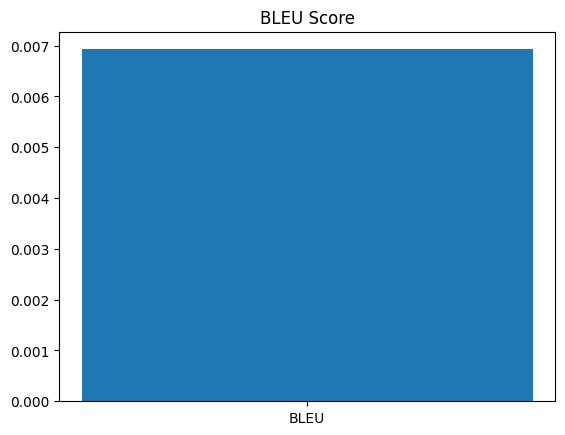

In [29]:
# BLEU Score
import evaluate
import matplotlib.pyplot as plt

# Evaluate BLEU
bleu = evaluate.load("bleu")
preds, refs = [], []

for example in test_processed["text"][:100]:
    inputs = example.split("<start_of_turn>user")[1].split("<end_of_turn>")[0]
    with torch.no_grad():
        outputs = tokenizer.decode(model.generate(**tokenizer(inputs, return_tensors="pt").to(model.device), max_new_tokens=128)[0], skip_special_tokens=True)
    preds.append(outputs)
    refs.append([example.split("<start_of_turn>model")[1].split("<end_of_turn>")[0]])

results = bleu.compute(predictions=preds, references=refs)
print("BLEU Score:", results["bleu"])

plt.bar(["BLEU"], [results["bleu"]])
plt.title("BLEU Score")
plt.show()


Perplexity: 57.43403602718883


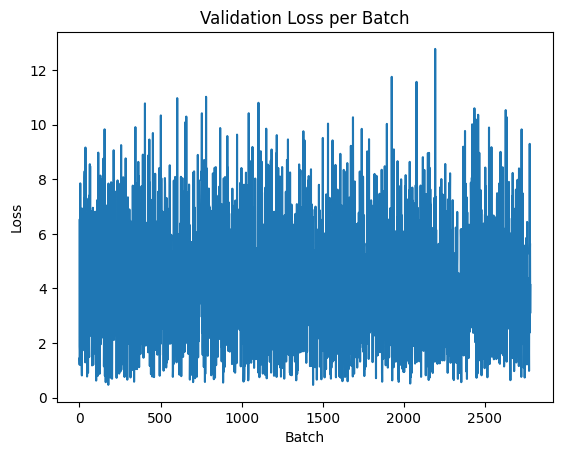

In [30]:
# Perplexity
import math, torch
import matplotlib.pyplot as plt

model.eval()
losses = []
for batch in DataLoader(test_processed, batch_size=2):
    inputs = tokenizer(batch["text"], return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    losses.append(loss.item())

ppl = math.exp(sum(losses) / len(losses))
print("Perplexity:", ppl)

plt.plot(losses)
plt.title("Validation Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# saving standalone tuned version
model = model.merge_and_unload()

model.save_pretrained("/kaggle/working/cura-merged")
tokenizer.save_pretrained("/kaggle/working/cura-merged")

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('/kaggle/working/cura-merged/tokenizer_config.json',
 '/kaggle/working/cura-merged/special_tokens_map.json',
 '/kaggle/working/cura-merged/tokenizer.model',
 '/kaggle/working/cura-merged/added_tokens.json',
 '/kaggle/working/cura-merged/tokenizer.json')

In [ ]:
from transformers import pipeline

# Load once
model, tokenizer = FastLanguageModel.from_pretrained(
    "/kaggle/working/cura-merged",
    max_seq_length=2048,
    load_in_4bit=True
)

FastLanguageModel.for_inference(model)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def process_query(user_input):
    labels = ["medical symptoms", "non-medical query"]
    result = classifier(user_input, candidate_labels=labels)
    if result["labels"][0] != "medical symptoms" or result["scores"][0] < 0.7:
        return "Sorry, I can only respond to health symptom descriptions."
    
    prompt = f"<start_of_turn>user\n{user_input}<end_of_turn>\n<start_of_turn>model\n"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    eos_id = tokenizer.convert_tokens_to_ids("<end_of_turn>")
    if eos_id is None:
        eos_id = tokenizer.eos_token_id

    output = model.generate(
        **inputs,
        max_new_tokens=128,
        temperature=0.0,
        do_sample=False,
        eos_token_id=eos_id,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(output[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response.replace("<end_of_turn>", "").strip()

# print(process_query("i have cough,mucus production,shortness of breath,chest pain"))
# print(process_query("what is the capital of kigali"))
print(process_query("i have fever,cough,sore throat,runny or stuffy nose,muscle aches,headache,fatigue"))

==((====))==  Unsloth 2025.10.3: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


Device set to use cuda:0


From your symptoms,you likely have garlic poisoning. I recommend you see a General Physician.


In [49]:
!zip -r /kaggle/working/cura-merged.zip /kaggle/working/cura-merged

updating: kaggle/working/cura-merged/ (stored 0%)
updating: kaggle/working/cura-merged/config.json (deflated 64%)
updating: kaggle/working/cura-merged/added_tokens.json (stored 0%)
updating: kaggle/working/cura-merged/special_tokens_map.json (deflated 77%)
updating: kaggle/working/cura-merged/generation_config.json (deflated 32%)
updating: kaggle/working/cura-merged/tokenizer.json (deflated 83%)
updating: kaggle/working/cura-merged/model.safetensors (deflated 20%)
updating: kaggle/working/cura-merged/tokenizer_config.json (deflated 97%)
updating: kaggle/working/cura-merged/tokenizer.model (deflated 52%)
